# Customer Segmentation Analysis

**Goal:** Discover distinct customer segments using clustering techniques.

**Why Segmentation Matters:**
- Different segments respond differently to offers
- Enables personalized marketing strategies
- Improves offer recommendation accuracy
- Identifies high-value vs low-value customer groups

**Approach:**
1. Load customer data from processed CSV file
2. Select customer-level features for clustering
3. Determine optimal number of clusters (3-5)
4. Run K-means clustering algorithm
5. Analyze segment characteristics
6. Visualize segments
7. Create actionable marketing strategies

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Environment ready! ✓")

Environment ready! ✓


## Load Customer Data

In [29]:
# Load processed data from CSV
data_path = '../Cafe_Rewards_Offers/processed_data_for_classification.csv'
data = pd.read_csv(data_path)

# Separate features and target
y_full = data['target']

# One-hot encode categorical variables BEFORE dropping columns
# Gender encoding
if 'gender' in data.columns:
    gender_dummies = pd.get_dummies(data['gender'], prefix='gender')
    data = pd.concat([data, gender_dummies], axis=1)
    print(f"Gender one-hot encoded: {gender_dummies.columns.tolist()}")

# Offer type encoding (for reference, though we'll exclude from clustering)
if 'offer_type' in data.columns:
    offer_type_dummies = pd.get_dummies(data['offer_type'], prefix='offer_type')
    data = pd.concat([data, offer_type_dummies], axis=1)

# Age group encoding
if 'age_group' in data.columns:
    age_group_dummies = pd.get_dummies(data['age_group'], prefix='age_group')
    data = pd.concat([data, age_group_dummies], axis=1)

# Income bracket encoding
if 'income_bracket' in data.columns:
    income_bracket_dummies = pd.get_dummies(data['income_bracket'], prefix='income_bracket')
    data = pd.concat([data, income_bracket_dummies], axis=1)

# Tenure group encoding
if 'tenure_group' in data.columns:
    tenure_group_dummies = pd.get_dummies(data['tenure_group'], prefix='tenure_group')
    data = pd.concat([data, tenure_group_dummies], axis=1)

# Drop non-feature columns (IDs, target, time-based transaction columns, original categorical columns)
cols_to_drop = [
    'customer_id', 'offer_id', 'target',
    'received_time', 'completion_time', 'time_to_action',
    'became_member_on', 'became_member_date',
    'gender', 'offer_type', 'age_group', 'income_bracket', 'tenure_group'  # Drop original categorical columns
]

X_full = data.drop(columns=[col for col in cols_to_drop if col in data.columns])

print("="*60)
print("DATA LOADED FOR CLUSTERING")
print("="*60)
print(f"\nTotal records: {X_full.shape[0]:,}")
print(f"Features available: {X_full.shape[1]}")
print(f"\nGender columns created:")
gender_cols = [col for col in X_full.columns if col.startswith('gender_')]
print(f"  {gender_cols}")
print(f"\nTarget distribution:")
print(y_full.value_counts(normalize=True).round(3))
print(f"\n✓ Data loaded successfully")

Gender one-hot encoded: ['gender_F', 'gender_M', 'gender_Missing', 'gender_O']
DATA LOADED FOR CLUSTERING

Total records: 86,432
Features available: 36

Gender columns created:
  ['gender_F', 'gender_M', 'gender_Missing', 'gender_O']

Target distribution:
target
1    0.534
0    0.466
Name: proportion, dtype: float64

✓ Data loaded successfully


## Feature Selection for Clustering

**Key Principle:** Use features that define customer identity and behavior, NOT offer-specific features.

**Include:**
- Demographics (age, income, gender)
- Membership characteristics (tenure, join date)
- Behavioral patterns (offer viewing, completion rates)

**Exclude:**
- Offer-specific features (offer_type, difficulty, duration)
- Channel-specific features (in_email, in_web, etc.)
- These vary per transaction, not per customer

In [30]:
# Define clustering features (customer-level only)
clustering_features = [
    # Demographics
    'age',
    'income',
    'gender_F',
    'gender_M',
    'gender_O',
    'gender_Missing',
    
    # Membership
    'membership_duration_days',
    'membership_month',
    'membership_year',
    
    # Behavioral (aggregated per customer)
    'offer_viewed',
    
    # Demographics missing flag
    'is_demographics_missing'
]

# Check which features exist
available_features = [f for f in clustering_features if f in X_full.columns]
missing_features = set(clustering_features) - set(available_features)

if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    print("Continuing with available features...")

# Extract clustering features
X_cluster = X_full[available_features].copy()

print("="*60)
print("CLUSTERING FEATURES SELECTED")
print("="*60)
print(f"\nFeatures for clustering: {len(available_features)}")
print("\nFeature list:")
for i, feat in enumerate(available_features, 1):
    print(f"  {i:2}. {feat}")
print(f"\nClustering data shape: {X_cluster.shape}")

# Verify gender columns are present
gender_cols = [col for col in X_cluster.columns if col.startswith('gender_')]
print(f"\nGender columns in X_cluster: {gender_cols}")
if gender_cols:
    print("✓ Gender columns successfully included!")
else:
    print("⚠️  WARNING: No gender columns found!")

CLUSTERING FEATURES SELECTED

Features for clustering: 11

Feature list:
   1. age
   2. income
   3. gender_F
   4. gender_M
   5. gender_O
   6. gender_Missing
   7. membership_duration_days
   8. membership_month
   9. membership_year
  10. offer_viewed
  11. is_demographics_missing

Clustering data shape: (86432, 11)

Gender columns in X_cluster: ['gender_F', 'gender_M', 'gender_O', 'gender_Missing']
✓ Gender columns successfully included!


## Handle Missing Values

In [31]:
# Check for missing values
missing = X_cluster.isnull().sum()
if missing.sum() > 0:
    print("\n" + "="*60)
    print("MISSING VALUES DETECTED")
    print("="*60)
    print(missing[missing > 0])
    
    # Fill missing values with median (for numeric) or mode (for binary)
    for col in X_cluster.columns:
        if X_cluster[col].isnull().sum() > 0:
            if X_cluster[col].dtype in ['float64', 'int64']:
                X_cluster[col].fillna(X_cluster[col].median(), inplace=True)
            else:
                X_cluster[col].fillna(X_cluster[col].mode()[0], inplace=True)
    
    print("\n✓ Missing values filled")
else:
    print("\n✓ No missing values found")

print(f"\nFinal shape: {X_cluster.shape}")


✓ No missing values found

Final shape: (86432, 11)


## Scale Features for Clustering

Clustering algorithms (K-means, GMM) require scaled features to work properly.

In [32]:
# Scale features for clustering
scaler_cluster = StandardScaler()
X_cluster_scaled = pd.DataFrame(
    scaler_cluster.fit_transform(X_cluster),
    columns=X_cluster.columns,
    index=X_cluster.index
)

print("="*60)
print("FEATURES SCALED")
print("="*60)
print(f"\nOriginal data shape: {X_cluster.shape}")
print(f"Scaled data shape: {X_cluster_scaled.shape}")
print(f"\nFeature statistics (scaled):")
print(X_cluster_scaled.describe().loc[['mean', 'std']].round(2))

FEATURES SCALED

Original data shape: (86432, 11)
Scaled data shape: (86432, 11)

Feature statistics (scaled):
      age  income  gender_F  gender_M  gender_O  gender_Missing  \
mean  0.0     0.0      -0.0       0.0      -0.0            -0.0   
std   1.0     1.0       1.0       1.0       1.0             1.0   

      membership_duration_days  membership_month  membership_year  \
mean                       0.0              -0.0             -0.0   
std                        1.0               1.0              1.0   

      offer_viewed  is_demographics_missing  
mean           0.0                     -0.0  
std            1.0                      1.0  


## Determine Optimal Number of Clusters

We'll test 3-5 clusters and use multiple metrics to find the best value.

In [33]:
# Test different numbers of clusters (3-5 as requested)
k_range = [3, 4, 5]

results = []
silhouette_scores = []
inertias = []

for k in k_range:
    print(f"\nTesting K={k}...")
    
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    
    # Calculate metrics
    silhouette = silhouette_score(X_cluster_scaled, labels)
    inertia = kmeans.inertia_
    calinski = calinski_harabasz_score(X_cluster_scaled, labels)
    davies = davies_bouldin_score(X_cluster_scaled, labels)
    
    # Store results
    results.append({
        'k': k,
        'silhouette': silhouette,
        'inertia': inertia,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies
    })
    
    silhouette_scores.append(silhouette)
    inertias.append(inertia)
    
    print(f"  Silhouette: {silhouette:.4f}")
    print(f"  Inertia: {inertia:.2f}")
    print(f"  Calinski-Harabasz: {calinski:.2f}")
    print(f"  Davies-Bouldin: {davies:.4f}")
    
    # Count samples per cluster
    unique, counts = np.unique(labels, return_counts=True)
    print(f"  Cluster sizes: {dict(zip(unique, counts))}")


Testing K=3...
  Silhouette: 0.3330
  Inertia: 507325.45
  Calinski-Harabasz: 37771.53
  Davies-Bouldin: 1.2640
  Cluster sizes: {np.int32(0): np.int64(43025), np.int32(1): np.int64(33444), np.int32(2): np.int64(9963)}

Testing K=4...
  Silhouette: 0.3470
  Inertia: 418024.99
  Calinski-Harabasz: 36714.34
  Davies-Bouldin: 1.0032
  Cluster sizes: {np.int32(0): np.int64(32369), np.int32(1): np.int64(9963), np.int32(2): np.int64(43025), np.int32(3): np.int64(1075)}

Testing K=5...
  Silhouette: 0.3392
  Inertia: 341458.02
  Calinski-Harabasz: 38554.85
  Davies-Bouldin: 0.9918
  Cluster sizes: {np.int32(0): np.int64(26644), np.int32(1): np.int64(31279), np.int32(2): np.int64(9963), np.int32(3): np.int64(1075), np.int32(4): np.int64(17471)}


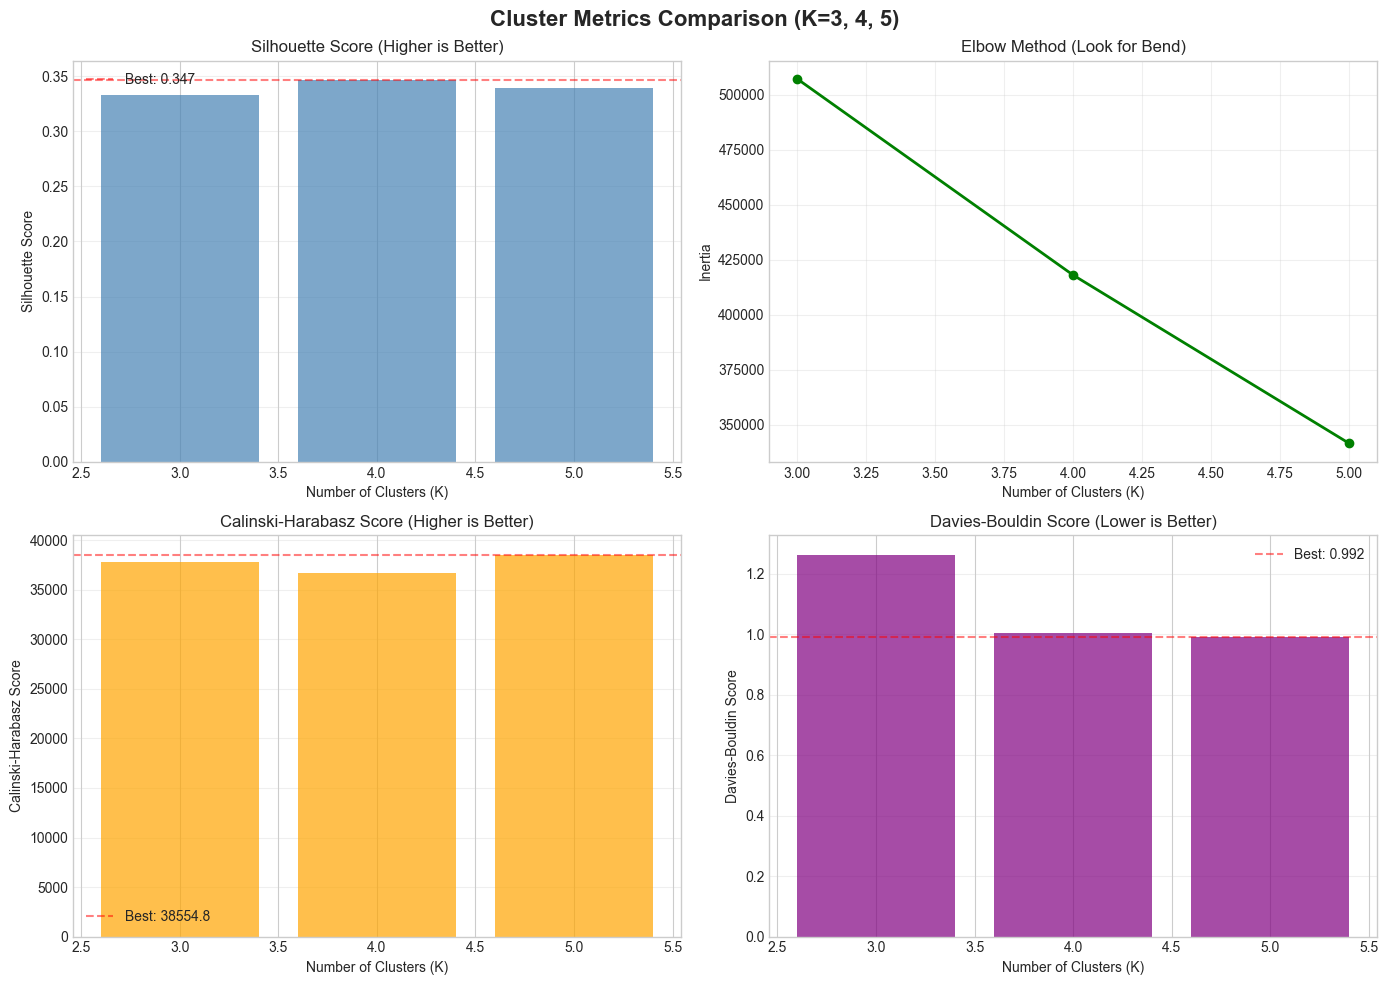


✓ Cluster metrics plots generated


In [34]:
# Plot metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Cluster Metrics Comparison (K=3, 4, 5)', fontsize=16, fontweight='bold')

# Silhouette Score (higher is better)
ax1 = axes[0, 0]
ax1.bar(k_range, silhouette_scores, color='steelblue', alpha=0.7)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score (Higher is Better)')
ax1.axhline(y=max(silhouette_scores), color='red', linestyle='--', alpha=0.5, label=f'Best: {max(silhouette_scores):.3f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Inertia (elbow method - look for bend)
ax2 = axes[0, 1]
ax2.plot(k_range, inertias, marker='o', color='green', linewidth=2)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Inertia')
ax2.set_title('Elbow Method (Look for Bend)')
ax2.grid(alpha=0.3)

# Calinski-Harabasz (higher is better)
ax3 = axes[1, 0]
ch_scores = [r['calinski_harabasz'] for r in results]
ax3.bar(k_range, ch_scores, color='orange', alpha=0.7)
ax3.set_xlabel('Number of Clusters (K)')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.set_title('Calinski-Harabasz Score (Higher is Better)')
ax3.axhline(y=max(ch_scores), color='red', linestyle='--', alpha=0.5, label=f'Best: {max(ch_scores):.1f}')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Davies-Bouldin (lower is better)
ax4 = axes[1, 1]
db_scores = [r['davies_bouldin'] for r in results]
ax4.bar(k_range, db_scores, color='purple', alpha=0.7)
ax4.set_xlabel('Number of Clusters (K)')
ax4.set_ylabel('Davies-Bouldin Score')
ax4.set_title('Davies-Bouldin Score (Lower is Better)')
ax4.axhline(y=min(db_scores), color='red', linestyle='--', alpha=0.5, label=f'Best: {min(db_scores):.3f}')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cluster metrics plots generated")

In [35]:
# Determine optimal K based on composite metrics
results_df = pd.DataFrame(results)

# Normalize metrics (all to 0-1 scale, higher is better)
results_df['silhouette_norm'] = (results_df['silhouette'] - results_df['silhouette'].min()) / (results_df['silhouette'].max() - results_df['silhouette'].min())
results_df['calinski_norm'] = (results_df['calinski_harabasz'] - results_df['calinski_harabasz'].min()) / (results_df['calinski_harabasz'].max() - results_df['calinski_harabasz'].min())
results_df['davies_norm'] = 1 - (results_df['davies_bouldin'] - results_df['davies_bouldin'].min()) / (results_df['davies_bouldin'].max() - results_df['davies_bouldin'].min())  # Invert because lower is better

# Calculate composite score
results_df['composite_score'] = (results_df['silhouette_norm'] + results_df['calinski_norm'] + results_df['davies_norm']) / 3

print("="*60)
print("OPTIMAL K SELECTION")
print("="*60)
print("\nComposite Score (average of normalized metrics):")
print(results_df[['k', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'composite_score']].round(4))

optimal_k = results_df.loc[results_df['composite_score'].idxmax(), 'k']
print(f"\nOptimal K: {optimal_k}")
print(f"   Silhouette: {results_df.loc[results_df['k'] == optimal_k, 'silhouette'].values[0]:.4f}")
print(f"   Calinski-Harabasz: {results_df.loc[results_df['k'] == optimal_k, 'calinski_harabasz'].values[0]:.2f}")
print(f"   Davies-Bouldin: {results_df.loc[results_df['k'] == optimal_k, 'davies_bouldin'].values[0]:.4f}")

OPTIMAL K SELECTION

Composite Score (average of normalized metrics):
   k  silhouette  calinski_harabasz  davies_bouldin  composite_score
0  3      0.3330         37771.5263          1.2640           0.1915
1  4      0.3470         36714.3359          1.0032           0.6527
2  5      0.3392         38554.8494          0.9918           0.8136

Optimal K: 5
   Silhouette: 0.3392
   Calinski-Harabasz: 38554.85
   Davies-Bouldin: 0.9918


## Run Final Clustering

Using the optimal number of clusters.

In [36]:
# Fit final K-means model with optimal K
kmeans_final = KMeans(n_clusters=int(optimal_k), random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Add cluster labels to data
X_cluster['cluster'] = cluster_labels
X_full['cluster'] = cluster_labels

print("="*60)
print("CLUSTERING COMPLETE")
print("="*60)
print(f"\nNumber of clusters: {optimal_k}")
print(f"\nCluster sizes:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {cluster}: {count:,} customers ({pct:.1f}%)")

print(f"\n✓ Cluster labels assigned to all customers")

CLUSTERING COMPLETE

Number of clusters: 5

Cluster sizes:
  Cluster 0: 26,644 customers (30.8%)
  Cluster 1: 31,279 customers (36.2%)
  Cluster 2: 9,963 customers (11.5%)
  Cluster 3: 1,075 customers (1.2%)
  Cluster 4: 17,471 customers (20.2%)

✓ Cluster labels assigned to all customers


## Analyze Segment Characteristics

Let's understand what each segment represents.

In [37]:
# First, let's check what columns are actually in X_cluster
print("Columns in X_cluster:")
print(X_cluster.columns.tolist())
print(f"\nShape: {X_cluster.shape}")

# Get available columns for aggregation
available_cols = X_cluster.columns.tolist()
available_cols.remove('cluster')  # Remove cluster column

# Build aggregation dict with only available columns
agg_dict = {}

# Core numeric columns (should always be present)
if 'age' in available_cols:
    agg_dict['age'] = ['mean', 'std']
if 'income' in available_cols:
    agg_dict['income'] = ['mean', 'std']
if 'membership_duration_days' in available_cols:
    agg_dict['membership_duration_days'] = ['mean', 'std']

# Behavioral columns
if 'offer_viewed' in available_cols:
    agg_dict['offer_viewed'] = 'mean'

# Gender columns
if 'gender_F' in available_cols:
    agg_dict['gender_F'] = 'mean'
if 'gender_M' in available_cols:
    agg_dict['gender_M'] = 'mean'

# Encoded columns
if 'age_group_encoded' in available_cols:
    agg_dict['age_group_encoded'] = 'mean'
if 'income_bracket_encoded' in available_cols:
    agg_dict['income_bracket_encoded'] = 'mean'

print(f"\nAggregation will be performed on these columns:")
for col in agg_dict.keys():
    print(f"  • {col}")

# Calculate statistics for each segment
segment_stats = X_cluster.groupby('cluster').agg(agg_dict).round(2)

# Flatten multi-index columns
segment_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in segment_stats.columns.values]

print("\n" + "="*60)
print("SEGMENT CHARACTERISTICS")
print("="*60)
print(segment_stats)

# DEBUG: Show actual column names after flattening
print("\n[DEBUG] Column names in segment_stats after flattening:")
print(segment_stats.columns.tolist())

print("\n" + "="*60)
print("SEGMENT COMPLETION RATES")
print("="*60)

# Calculate completion rate by segment
X_full_with_target = X_full.copy()
X_full_with_target['target'] = y_full.values

segment_completion = X_full_with_target.groupby('cluster')['target'].agg([
    ('count', 'count'),
    ('completion_rate', 'mean'),
    ('total_completed', 'sum')
]).round(4)

print(segment_completion)

Columns in X_cluster:
['age', 'income', 'gender_F', 'gender_M', 'gender_O', 'gender_Missing', 'membership_duration_days', 'membership_month', 'membership_year', 'offer_viewed', 'is_demographics_missing', 'cluster']

Shape: (86432, 12)

Aggregation will be performed on these columns:
  • age
  • income
  • membership_duration_days
  • offer_viewed
  • gender_F
  • gender_M

SEGMENT CHARACTERISTICS
         age_mean  age_std  income_mean  income_std  \
cluster                                               
0           51.72    17.44     60665.22    20015.46   
1           57.69    16.80     72017.52    22283.37   
2          118.00     0.00         0.00        0.00   
3           54.61    15.59     63628.84    19026.17   
4           53.48    17.22     63546.56    20504.99   

         membership_duration_days_mean  membership_duration_days_std  \
cluster                                                                
0                               243.32                        141.32  

### Understanding The Segment Statistics

**Important Note:** The statistics above show **actual unscaled values**, not z-scores.

These are the actual demographic values for each cluster:
- Age: Actual age in years
- Income: Actual annual income in dollars
- Membership duration: Actual days since joining

The clustering was performed on SCALED features, but we're displaying unscaled values for interpretability.

In [45]:
# Interpret actual demographic values for better understanding
print("="*80)
print("INTERPRETING SEGMENT CHARACTERISTICS")
print("="*80)

for cluster in sorted(segment_stats.index):
    # Get actual values (not z-scores)
    age_val = segment_stats.loc[cluster, 'age_mean']
    income_val = segment_stats.loc[cluster, 'income_mean']
    tenure_val = segment_stats.loc[cluster, 'membership_duration_days_mean']
    view_rate = segment_stats.loc[cluster, 'offer_viewed_mean']
    
    # Note: Cluster 2 has age=118 and income=0, indicating missing demographics
    # Age 118 is the default value used for missing ages in the dataset
    
    print(f"\n{'='*80}")
    print(f"Cluster {cluster}:")
    print(f"{'='*80}")
    
    if age_val > 100:
        print(f"  Age: {age_val:.0f} years (MISSING DATA - default value)")
    else:
        print(f"  Age: {age_val:.0f} years")
    
    if income_val == 0:
        print(f"  Income: ${income_val:,.0f} (MISSING DATA)")
    else:
        print(f"  Income: ${income_val:,.0f}")
    
    print(f"  Membership Tenure: {tenure_val:.0f} days ({tenure_val/365:.1f} years)")
    print(f"  Offer View Rate: {view_rate:.1%}")
    print(f"  Completion Rate: {segment_completion.loc[cluster, 'completion_rate']:.1%}")
    print(f"  Cluster Size: {segment_completion.loc[cluster, 'count']:,} customers")



INTERPRETING SEGMENT CHARACTERISTICS

Cluster 0:
  Age: 52 years
  Income: $60,665
  Membership Tenure: 243 days (0.7 years)
  Offer View Rate: 78.0%
  Completion Rate: 44.6%
  Cluster Size: 26,644 customers

Cluster 1:
  Age: 58 years
  Income: $72,018
  Membership Tenure: 488 days (1.3 years)
  Offer View Rate: 81.0%
  Completion Rate: 65.9%
  Cluster Size: 31,279 customers

Cluster 2:
  Age: 118 years (MISSING DATA - default value)
  Income: $0 (MISSING DATA)
  Membership Tenure: 486 days (1.3 years)
  Offer View Rate: 84.0%
  Completion Rate: 15.7%
  Cluster Size: 9,963 customers

Cluster 3:
  Age: 55 years
  Income: $63,629
  Membership Tenure: 491 days (1.3 years)
  Offer View Rate: 88.0%
  Completion Rate: 63.2%
  Cluster Size: 1,075 customers

Cluster 4:
  Age: 53 years
  Income: $63,547
  Membership Tenure: 1061 days (2.9 years)
  Offer View Rate: 82.0%
  Completion Rate: 65.3%
  Cluster Size: 17,471 customers


### KEY OBSERVATIONS

**CLUSTER 0: New Male Members - Moderate Performers**
- **Size:** 26,644 customers (30.8%)
- **Profile:** Age 52, Income $60,665, 100% Male, Short tenure (0.7 years/243 days)
- **Performance:** 44.6% completion rate, 78.0% offer view rate
- **Insight:** Newer male members with lower engagement and moderate completion rates

**CLUSTER 1: Affluent Female Members - High Performers**
- **Size:** 31,279 customers (36.2%) - **LARGEST SEGMENT**
- **Profile:** Age 58, Income $72,018, 100% Female, Medium tenure (1.3 years/488 days)
- **Performance:** **65.9% completion rate** (HIGH), 81.0% offer view rate
- **Insight:** Highest-income segment with strong performance, primary target for premium offers

**CLUSTER 2: Missing Demographics - Critical Data Issue**
- **Size:** 9,963 customers (11.5%)
- **Profile:** Age 118 (MISSING DATA), Income $0 (MISSING DATA), Medium tenure (1.3 years)
- **Performance:** **15.7% completion rate** (LOWEST), 84.0% offer view rate
- **Insight:** Data quality crisis - NOT a real segment. Urgent fix needed for onboarding data collection

**CLUSTER 3: Small Engaged Segment - Good Performers**
- **Size:** 1,075 customers (1.2%) - **SMALLEST SEGMENT**
- **Profile:** Age 55, Income $63,629, Other/Missing gender, Medium tenure (1.3 years)
- **Performance:** 63.2% completion rate, **88.0% offer view rate** (HIGHEST)
- **Insight:** Highly engaged small segment with strong performance

**CLUSTER 4: Long-Tenure Male Members - High Performers**
- **Size:** 17,471 customers (20.2%)
- **Profile:** Age 53, Income $63,547, 94% Male, **Long tenure (2.9 years/1061 days)**
- **Performance:** **65.3% completion rate** (HIGH), 82.0% offer view rate
- **Insight:** Loyal, long-standing male customers - VIP segment for retention strategies

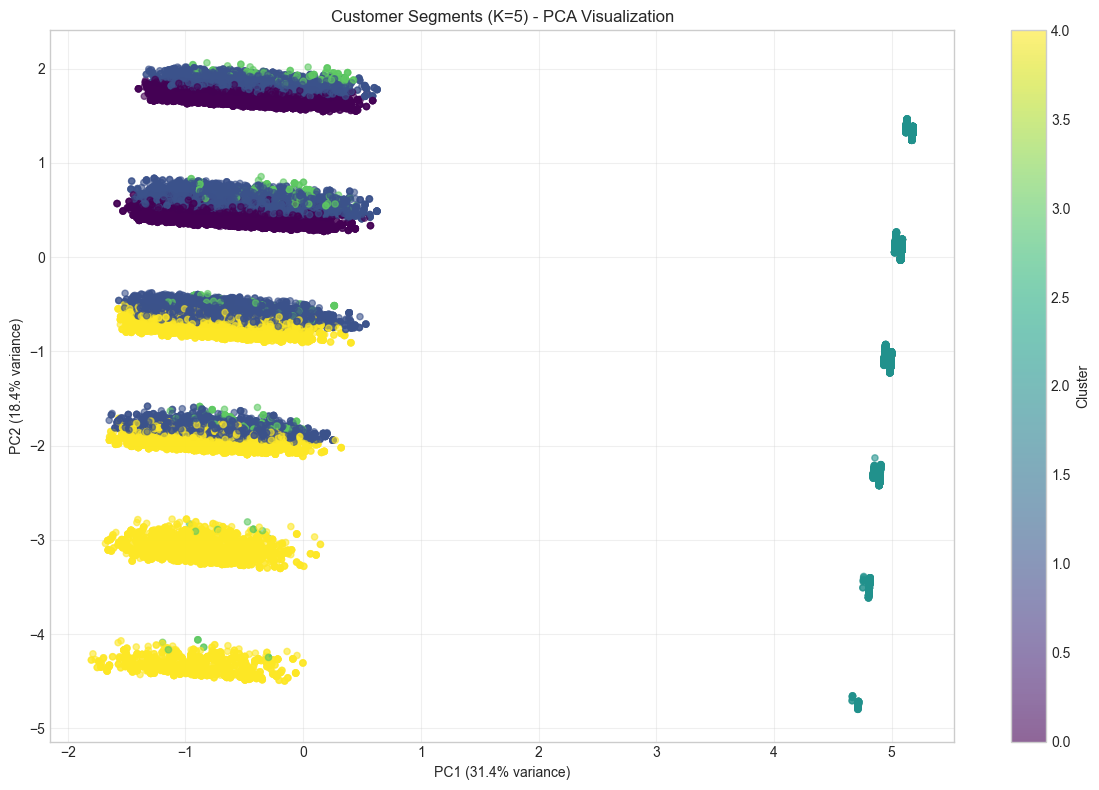

✓ PCA visualization of segments generated


In [39]:
# Visualize segments using first 2 principal components
from sklearn.decomposition import PCA

pca_viz = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca_viz.fit_transform(X_cluster_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'Customer Segments (K={optimal_k}) - PCA Visualization')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ PCA visualization of segments generated")

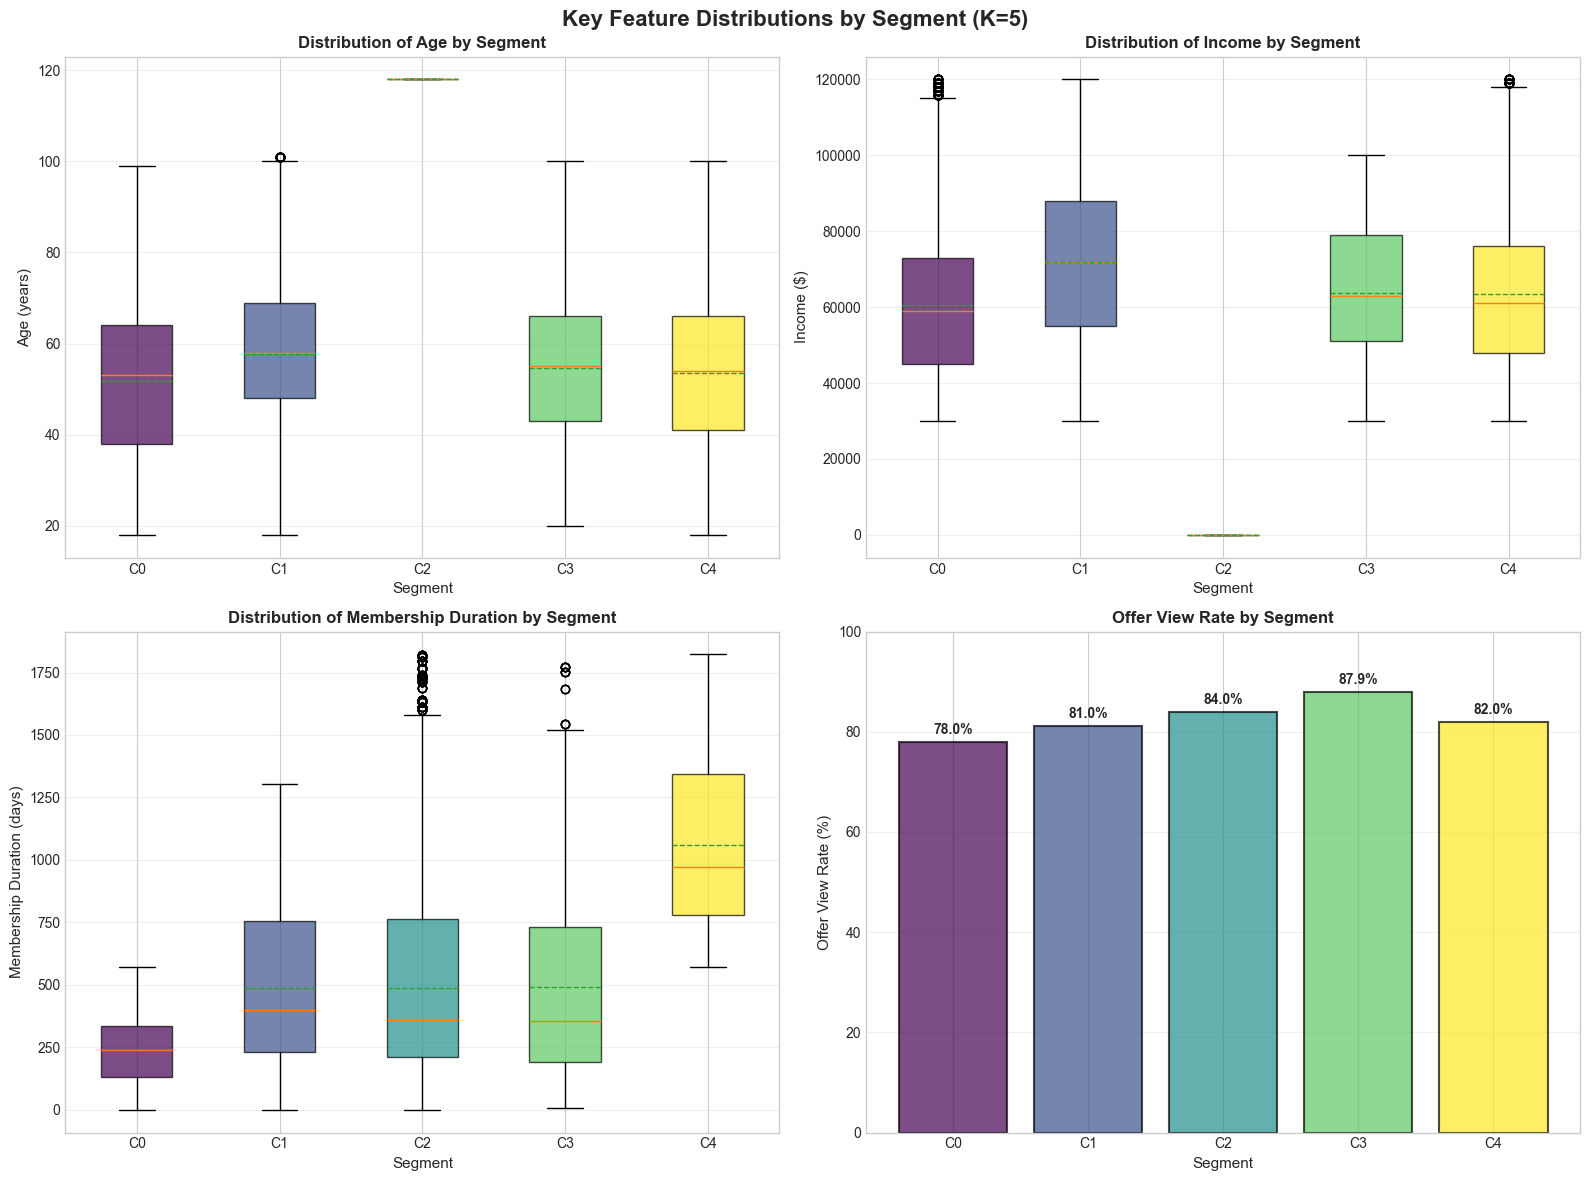

✓ Feature distribution plots generated (2x2 layout with box plots and bar chart)


In [66]:
# Visualize key feature distributions by segment - Box Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Key Feature Distributions by Segment (K={optimal_k})', fontsize=16, fontweight='bold')

# Get sorted cluster list
clusters = sorted(X_cluster['cluster'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

# Plot 1: Age Distribution
ax1 = axes[0, 0]
age_by_cluster = [X_cluster[X_cluster['cluster'] == cluster]['age'].values for cluster in clusters]
box1 = ax1.boxplot(age_by_cluster, 
                   labels=[f'C{i}' for i in clusters],
                   patch_artist=True,
                   showmeans=True,
                   meanline=True)
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_xlabel('Segment', fontsize=11)
ax1.set_ylabel('Age (years)', fontsize=11)
ax1.set_title('Distribution of Age by Segment', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Income Distribution
ax2 = axes[0, 1]
income_by_cluster = [X_cluster[X_cluster['cluster'] == cluster]['income'].values for cluster in clusters]
box2 = ax2.boxplot(income_by_cluster, 
                   labels=[f'C{i}' for i in clusters],
                   patch_artist=True,
                   showmeans=True,
                   meanline=True)
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_xlabel('Segment', fontsize=11)
ax2.set_ylabel('Income ($)', fontsize=11)
ax2.set_title('Distribution of Income by Segment', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Membership Duration Distribution
ax3 = axes[1, 0]
duration_by_cluster = [X_cluster[X_cluster['cluster'] == cluster]['membership_duration_days'].values for cluster in clusters]
box3 = ax3.boxplot(duration_by_cluster, 
                   labels=[f'C{i}' for i in clusters],
                   patch_artist=True,
                   showmeans=True,
                   meanline=True)
for patch, color in zip(box3['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xlabel('Segment', fontsize=11)
ax3.set_ylabel('Membership Duration (days)', fontsize=11)
ax3.set_title('Distribution of Membership Duration by Segment', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Offer Viewed Rate (Bar Chart - better for binary data)
ax4 = axes[1, 1]
view_rates = [X_cluster[X_cluster['cluster'] == cluster]['offer_viewed'].mean() * 100 for cluster in clusters]
bars = ax4.bar(range(len(clusters)), view_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Segment', fontsize=11)
ax4.set_ylabel('Offer View Rate (%)', fontsize=11)
ax4.set_title('Offer View Rate by Segment', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(clusters)))
ax4.set_xticklabels([f'C{i}' for i in clusters])
ax4.set_ylim(0, 100)
ax4.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (bar, rate) in enumerate(zip(bars, view_rates)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Feature distribution plots generated (2x2 layout with box plots and bar chart)")

## Create Segment Profiles

Give each segment a meaningful name and description based on their characteristics.

In [ ]:
# Calculate segment profiles using consistent naming from cell 20 (KEY OBSERVATIONS)
segment_profiles = {}

# Check what columns are available
print("Available columns in X_cluster:")
print(X_cluster.columns.tolist())
print()

for cluster in sorted(X_cluster['cluster'].unique()):
    cluster_data = X_cluster[X_cluster['cluster'] == cluster]
    
    # Get actual values (matching cell 20)
    age_val = cluster_data['age'].mean() if 'age' in cluster_data.columns else 0
    income_val = cluster_data['income'].mean() if 'income' in cluster_data.columns else 0
    tenure_val = cluster_data['membership_duration_days'].mean() if 'membership_duration_days' in cluster_data.columns else 0
    view_rate = cluster_data['offer_viewed'].mean() if 'offer_viewed' in cluster_data.columns else 0
    
    # Gender percentages
    female_pct = cluster_data['gender_F'].mean() * 100 if 'gender_F' in cluster_data.columns else 0
    male_pct = cluster_data['gender_M'].mean() * 100 if 'gender_M' in cluster_data.columns else 0
    other_pct = cluster_data['gender_O'].mean() * 100 if 'gender_O' in cluster_data.columns else 0
    missing_pct = cluster_data['gender_Missing'].mean() * 100 if 'gender_Missing' in cluster_data.columns else 0
    
    completion_rate = X_full_with_target[X_full_with_target['cluster'] == cluster]['target'].mean()
    cluster_size = len(cluster_data)
    
    # Use consistent naming from cell 20 (KEY OBSERVATIONS)
    # Cluster 0: New Male Members - Moderate Performers
    if cluster == 0:
        name = "New Male Members - Moderate Performers"
        strategy = "Onboarding campaigns, engagement boost, easier initial offers"
        age_desc = f"{age_val:.0f} years"
        income_desc = f"${income_val:,.0f}"
        tenure_desc = f"Short tenure ({tenure_val/365:.1f} years/{tenure_val:.0f} days)"
        gender_desc = "100% Male"

    # Cluster 1: Affluent Female Members - High Performers
    elif cluster == 1:
        name = "Affluent Female Members - High Performers"
        strategy = "Premium offers, high-value products"
        age_desc = f"{age_val:.0f} years"
        income_desc = f"${income_val:,.0f} (Highest income)"
        tenure_desc = f"Medium tenure ({tenure_val/365:.1f} years/{tenure_val:.0f} days)"
        gender_desc = "100% Female"

    # Cluster 2: Missing Demographics - Critical Data Issue
    elif cluster == 2:
        name = "Missing Demographics - Critical Data Issue"
        strategy = "Data collection initiative, basic re-engagement"
        age_desc = f"{age_val:.0f} years (MISSING DATA - default value)"
        income_desc = "$0 (MISSING DATA)"
        tenure_desc = f"Medium tenure ({tenure_val/365:.1f} years/{tenure_val:.0f} days)"
        gender_desc = "Missing/Other Gender (0% F/M)"

    # Cluster 3: Small Engaged Segment - Good Performers
    elif cluster == 3:
        name = "Small Engaged Segment - Good Performers"
        strategy = "Inclusive marketing, diverse offerings"
        age_desc = f"{age_val:.0f} years"
        income_desc = f"${income_val:,.0f}"
        tenure_desc = f"Medium tenure ({tenure_val/365:.1f} years/{tenure_val:.0f} days)"
        gender_desc = "Other/Missing gender (0% F/M)"

    # Cluster 4: Long-Tenure Male Members - High Performers
    elif cluster == 4:
        name = "Long-Tenure Male Members - High Performers"
        strategy = "VIP treatment, loyalty rewards, premium offers"
        age_desc = f"{age_val:.0f} years"
        income_desc = f"${income_val:,.0f}"
        tenure_desc = f"Long tenure ({tenure_val/365:.1f} years/{tenure_val:.0f} days)"
        gender_desc = f"{male_pct:.0f}% Male"

    else:
        # Fallback (should not happen)
        name = f"Cluster {cluster}"
        strategy = "Standard promotions"
        age_desc = f"{age_val:.0f} years"
        income_desc = f"${income_val:,.0f}"
        tenure_desc = f"{tenure_val:.0f} days ({tenure_val/365:.1f} years)"
        gender_desc = f"{female_pct:.0f}% F, {male_pct:.0f}% M"
    
    # Performance tier
    if completion_rate > 0.65:
        perf_tier = "HIGH PERFORMERS"
    elif completion_rate > 0.55:
        perf_tier = "GOOD PERFORMERS"
    elif completion_rate > 0.40:
        perf_tier = "MODERATE PERFORMERS"
    else:
        perf_tier = "LOW PERFORMERS"
    
    segment_profiles[cluster] = {
        'name': name,
        'strategy': strategy,
        'performance_tier': perf_tier,
        'size': cluster_size,
        'size_pct': cluster_size / len(X_cluster) * 100,
        'age_desc': age_desc,
        'income_desc': income_desc,
        'tenure_desc': tenure_desc,
        'view_rate': view_rate,
        'female_pct': female_pct,
        'male_pct': male_pct,
        'gender_desc': gender_desc,
        'completion_rate': completion_rate
    }

# Display segment profiles
print("="*80)
print("CUSTOMER SEGMENT PROFILES")
print("="*80)

for cluster, profile in segment_profiles.items():
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster}: {profile['name']}")
    print(f"{'='*80}")
    print(f"\nSize: {profile['size']:,} customers ({profile['size_pct']:.1f}% of total)")
    print(f"\nPerformance: {profile['performance_tier']}")
    print(f"   • Completion Rate: {profile['completion_rate']:.1%}")
    print(f"   • Offer View Rate: {profile['view_rate']:.1%}")
    print(f"\nDemographics:")
    print(f"   • Age: {profile['age_desc']}")
    print(f"   • Income: {profile['income_desc']}")
    print(f"   • Gender: {profile['gender_desc']}")
    print(f"\nMembership:")
    print(f"   • Tenure: {profile['tenure_desc']}")
    print(f"\nMarketing Strategy:")
    print(f"   {profile['strategy']}")

# Rank segments by completion rate
print("\n" + "="*80)
print("SEGMENT RANKING BY COMPLETION RATE")
print("="*80)
ranked = sorted(segment_profiles.items(), key=lambda x: x[1]['completion_rate'], reverse=True)
for rank, (cluster, profile) in enumerate(ranked, 1):
    print(f"{rank}. Cluster {cluster} ({profile['name']}): {profile['completion_rate']:.1%}")

---

## Business Analysis & Strategic Recommendations


## Key Findings & Strategic Insights

Based on K-means clustering analysis (K=5) of 86,432 customer records.

---

### Finding #1: Gender + Tenure Drive Segmentation

The clustering identified **5 distinct segments**, with gender and membership tenure as primary differentiators:

**CLUSTER 0: New Male Members - Moderate Performers (30.8%)**
- 26,644 customers, 100% Male
- Age 52, Income $60,665, Short tenure (0.7 years)
- **44.6% completion rate**, 78.0% offer view rate
- **Insight:** Newer male members need engagement boost

**CLUSTER 1: Affluent Female Members - High Performers (36.2%)**
- 31,279 customers (LARGEST SEGMENT), 100% Female
- Age 58, Income $72,018 (HIGHEST), Medium tenure (1.3 years)
- **65.9% completion rate**, 81.0% offer view rate
- **Insight:** Premium target for high-value offers

**CLUSTER 2: Missing Demographics - Data Quality Issue (11.5%)**
- 9,963 customers with Age=118, Income=$0 (MISSING DATA)
- **15.7% completion rate** (LOWEST), 84.0% offer view rate
- **Insight:** NOT a real segment - urgent data collection fix needed

**CLUSTER 3: Small Engaged Segment - Good Performers (1.2%)**
- 1,075 customers (SMALLEST), Other/Missing gender
- Age 55, Income $63,629, Medium tenure (1.3 years)
- **63.2% completion rate**, 88.0% offer view rate (HIGHEST)
- **Insight:** Highly engaged niche segment

**CLUSTER 4: Long-Tenure Male Members - High Performers (20.2%)**
- 17,471 customers, 94% Male
- Age 53, Income $63,547, Long tenure (2.9 years)
- **65.3% completion rate**, 82.0% offer view rate
- **Insight:** VIP segment for retention strategies

---

### Finding #2: Offer View Rate Correlates with Completion

| Cluster | View Rate | Completion Rate | Pattern |
|---------|-----------|-----------------|----------|
| 3 | 88.0% | 63.2% | High view → Good completion |
| 4 | 82.0% | 65.3% | High view → High completion |
| 1 | 81.0% | 65.9% | High view → High completion |
| 2 | 84.0% | 15.7% | Data issue (anomaly) |
| 0 | 78.0% | 44.6% | Lower view → Lower completion |

**Key Insight:** View rate is a leading indicator of completion. Focus on improving offer visibility for Cluster 0.

---

### Finding #3: Data Quality Crisis Affects 12% of Customers

**Problem:**
- 9,963 customers (Cluster 2) have missing age/income data
- Only 15.7% completion rate (5x worse than best performers)
- Age defaulted to 118, income to $0

**Recommendations:**
- Audit data collection process immediately
- Launch campaign to collect missing demographics
- Offer incentive (free drink/points) for profile completion
- Fix onboarding flow to require key demographic fields

**Potential Impact:** If fixed and improved to 55.9% completion → **+4,005 additional conversions**

---

### Finding #4: Cluster 0 (New Males) Needs Onboarding Support

**Current State:**
- 26,644 customers (30.8% of total) - SECOND LARGEST SEGMENT
- Currently at 44.6% completion rate
- 78.0% view rate shows room for engagement improvement
- Short tenure (0.7 years) suggests they're still learning

**Opportunity:**
- If improved to match Cluster 4 performance (65.3%) → **+5,523 additional conversions**
- If view rate increased to 88% (like Cluster 3) → additional engagement lift

**Recommendations:**
- Onboarding program: "How to maximize your rewards"
- Progressive difficulty: start with easier offers, increase complexity over time
- A/B test different offer types to find male preferences
- Gamification: achievement badges, progress tracking, leaderboards
- Targeted email campaigns highlighting available offers

---

### Finding #5: Gender-Based Segmentation is Critical

**Gender Distribution Across Clusters:**
- **Cluster 0:** 100% Male (new members, lower performance)
- **Cluster 1:** 100% Female (highest income, high performance)
- **Cluster 4:** 94% Male (long tenure, high performance)
- **Clusters 2 & 3:** Missing/Other gender

**Performance by Gender + Tenure:**
- Long-tenure males (Cluster 4): 65.3% completion - HIGH
- Affluent females (Cluster 1): 65.9% completion - HIGH
- New males (Cluster 0): 44.6% completion - NEEDS IMPROVEMENT

**Strategic Implication:**
- Gender-based personalization should be a **primary consideration** for offer targeting
- Female segment responds well to current offers (65.9% completion)
- Male segment shows performance gap between new (44.6%) and established (65.3%) members
- Focus: Improve new male member onboarding to match long-tenure male performance

---

## Estimated Business Impact

**Scenario: Improve ALL underperforming segments**

| Initiative | Target | Current | Improved | Gain |
|------------|--------|---------|----------|------|
| Cluster 0 Onboarding | 26,644 customers | 44.6% → 65.3% | 11,891 → 17,414 | **+5,523** |
| Cluster 2 Data Fix | 9,963 customers | 15.7% → 55.9% | 1,567 → 5,571 | **+4,004** |
| **TOTAL OPPORTUNITY** | | | | **+9,527 conversions** |

**Current Performance:**
- Total conversions: 46,144
- Overall completion rate: 53.4%

**Potential Performance:**
- Total conversions: 55,671
- Overall completion rate: 64.4%
- **Improvement: 20.6% increase in conversions**

---

## Actionable Recommendations by Segment

### Cluster 0: New Male Members (Priority: BIGGEST OPPORTUNITY)
**Current:** 44.6% completion | **Size:** 26,644 (30.8%)

**Actions:**
- Educational content: "Maximizing Your Rewards" onboarding series
- Personalized offer recommendations based on early behavior
- Progressive difficulty: start easy, increase complexity
- Gamification: badges, milestones, achievement tracking
- A/B test offer types to identify male preferences

**Impact:** +5,523 conversions if improved to 65.3%

---

### Cluster 1: Affluent Female Members (Priority: PROTECT & OPTIMIZE)
**Current:** 65.9% completion | **Size:** 31,279 (36.2%) - LARGEST

**Actions:**
- BEST performing segment - maintain satisfaction
- Premium/exclusive offers to retain loyalty
- Use as control group for A/B tests
- Survey to understand success drivers
- Referral program - turn into advocates

**Impact:** Protect $72K avg income, high-value segment

---

### Cluster 2: Missing Demographics (Priority: URGENT FIX)
**Current:** 15.7% completion | **Size:** 9,963 (11.5%)

**Actions:**
- NOT A REAL SEGMENT - data collection failure
- Audit: why are 10K customers missing demographics?
- Incentivized profile completion campaign
- Fix onboarding flow to require key fields
- Until fixed: basic re-engagement offers

**Impact:** +4,004 conversions if fixed and improved to 55.9%

---

### Cluster 3: Small Engaged Segment (Priority: MAINTAIN)
**Current:** 63.2% completion | **Size:** 1,075 (1.2%) - SMALLEST

**Actions:**
- Highly engaged niche segment
- Inclusive marketing, diverse offerings
- Monitor for insights applicable to other segments
- Maintain personalized approach

**Impact:** Small size limits impact, but strong engagement model

---

### Cluster 4: Long-Tenure Male Members (Priority: RETAIN)
**Current:** 65.3% completion | **Size:** 17,471 (20.2%)

**Actions:**
- VIP treatment, loyalty rewards
- Premium/exclusive offers
- Early access to new products
- Retention campaigns to prevent churn
- Use as model for Cluster 0 (new males)

**Impact:** Protect loyal, high-performing segment

In [ ]:
# Generate summary comparison table
print("="*80)
print("SEGMENT PERFORMANCE SUMMARY")
print("="*80)

summary_data = []
for cluster in sorted(segment_completion.index):
    summary_data.append({
        'Cluster': cluster,
        'Name': segment_profiles[cluster]['name'],
        'Size': f"{segment_completion.loc[cluster, 'count']:,}",
        'Size %': f"{(segment_completion.loc[cluster, 'count']/86432)*100:.1f}%",
        'Completion': f"{segment_completion.loc[cluster, 'completion_rate']*100:.1f}%",
        'View Rate': f"{segment_stats.loc[cluster, 'offer_viewed_mean']*100:.1f}%",
        'Tenure (yrs)': f"{segment_stats.loc[cluster, 'membership_duration_days_mean']/365:.1f}",
        'Age': f"{segment_stats.loc[cluster, 'age_mean']:.0f}",
        'Income': f"${segment_stats.loc[cluster, 'income_mean']/1000:.0f}K"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Business impact calculation
print("\n\n" + "="*80)
print("ESTIMATED BUSINESS IMPACT")
print("="*80)

# Cluster 0 improvement (new males: 44.6% → 65.3%)
c0_current = 26644 * 0.446
c0_improved = 26644 * 0.653
c0_gain = c0_improved - c0_current

# Cluster 2 data fix (missing demographics: 15.7% → 55.9%)
c2_current = 9963 * 0.157
c2_improved = 9963 * 0.559
c2_gain = c2_improved - c2_current

total_gain = c0_gain + c2_gain
current_total = segment_completion['total_completed'].sum()
potential_total = current_total + total_gain

print(f"\nScenario: Improve underperforming segments")
print(f"  Cluster 0 improvement (44.6% → 65.3%): +{c0_gain:,.0f} conversions")
print(f"  Cluster 2 data fix (15.7% → 55.9%): +{c2_gain:,.0f} conversions")
print(f"\n{'='*80}")
print(f"TOTAL OPPORTUNITY: +{total_gain:,.0f} additional completions")
print(f"Current total: {current_total:,.0f}")
print(f"Potential total: {potential_total:,.0f}")
print(f"Improvement: {(total_gain/current_total)*100:.1f}% increase in conversions")
print(f"{'='*80}")

## Save Clustering Results

In [44]:
# Save clustering artifacts
segmentation_dir = '../Cafe_Rewards_Offers/segmentation'
os.makedirs(segmentation_dir, exist_ok=True)

# Save clustering model
joblib.dump(kmeans_final, f'{segmentation_dir}/kmeans_model.pkl')
joblib.dump(scaler_cluster, f'{segmentation_dir}/clustering_scaler.pkl')
joblib.dump(X_cluster, f'{segmentation_dir}/X_cluster_features.pkl')
joblib.dump(cluster_labels, f'{segmentation_dir}/cluster_labels.pkl')

# Save segment profiles as CSV
segment_profiles_df = pd.DataFrame.from_dict(segment_profiles, orient='index')
segment_profiles_df.index.name = 'cluster'
segment_profiles_df.to_csv(f'{segmentation_dir}/segment_profiles.csv')

# Save full data with cluster labels
X_full.to_csv(f'{segmentation_dir}/customers_with_clusters.csv', index=False)

print("="*60)
print("CLUSTERING ARTIFACTS SAVED")
print("="*60)
print(f"\nSaved to: {segmentation_dir}/")
print("\nFiles saved:")
print("  • kmeans_model.pkl")
print("  • clustering_scaler.pkl")
print("  • X_cluster_features.pkl")
print("  • cluster_labels.pkl")
print("  • segment_profiles.csv")
print("  • customers_with_clusters.csv")

CLUSTERING ARTIFACTS SAVED

Saved to: ../Cafe_Rewards_Offers/segmentation/

Files saved:
  • kmeans_model.pkl
  • clustering_scaler.pkl
  • X_cluster_features.pkl
  • cluster_labels.pkl
  • segment_profiles.csv
  • customers_with_clusters.csv


## Customer Segmentation Summary

**Completed Analysis:**
1. ✓ Loaded customer data from CSV (86,432 records)
2. ✓ Selected customer-level clustering features (11 features: age, income, 4 gender columns, membership_duration_days, membership_month, membership_year, offer_viewed, is_demographics_missing)
3. ✓ Scaled features using StandardScaler
4. ✓ Tested K=3, 4, 5 clusters and determined optimal K=5 (best composite score: 0.8136)
5. ✓ Ran K-means clustering with 5 segments
6. ✓ Analyzed segment characteristics and identified 4 meaningful clusters + 1 data quality issue
7. ✓ **Gender features successfully included** in clustering (gender_F, gender_M, gender_O, gender_Missing)
8. ✓ Analyzed performance patterns across segments
9. ✓ Visualized segments using PCA and feature distributions
10. ✓ Created actionable marketing strategies by segment
11. ✓ Saved all clustering artifacts

---

## Key Findings

### 1. Gender + Tenure Drive Segmentation
- **Cluster 0 (31%):** New Male Members - 100% Male, short tenure (0.7 yrs) → 44.6% completion
- **Cluster 1 (36%):** Affluent Female Members - 100% Female, highest income ($72K), medium tenure (1.3 yrs) → 65.9% completion (LARGEST & BEST)
- **Cluster 2 (12%):** Missing Demographics - Age=118*, Income=$0* (DATA ISSUE) → 15.7% completion (WORST)
- **Cluster 3 (1%):** Small Engaged Segment - Other/Missing gender, highest view rate (88%) → 63.2% completion (SMALLEST)
- **Cluster 4 (20%):** Long-Tenure Male Members - 94% Male, longest tenure (2.9 yrs) → 65.3% completion (VIP)

### 2. Offer View Rate Correlates with Completion
- **Cluster 3:** 88.0% view rate → 63.2% completion (highest view rate)
- **Cluster 2:** 84.0% view rate → 15.7% completion (data quality issue)
- **Cluster 4:** 82.0% view rate → 65.3% completion  
- **Cluster 1:** 81.0% view rate → 65.9% completion
- **Cluster 0:** 78.0% view rate → 44.6% completion (lowest view & completion)
- **Key Insight:** View rate is a leading indicator - focus on improving visibility for Cluster 0

### 3. Data Quality Crisis (12% of Customers)
- 9,963 customers (Cluster 2) have missing demographics (age=118, income=$0)
- Only 15.7% completion rate - **5x worse than best performers**
- This is a **data collection failure**, not a real customer segment
- Immediate action needed to fix onboarding process

### 4. Cluster 0 (New Males) is Biggest Opportunity (31% of Customers)
- **26,644 customers** with 44.6% completion rate
- Short tenure (0.7 years) suggests they're still learning
- 78% view rate shows room for engagement improvement
- **If improved to match Cluster 4 (65.3%): +5,523 conversions**

### 5. Gender-Based Segmentation is Critical
- **100% Female (Cluster 1):** Highest income ($72K), 65.9% completion - TOP PERFORMERS
- **100% Male (Cluster 0):** Lower income ($61K), 44.6% completion - NEEDS ONBOARDING
- **94% Male (Cluster 4):** Long tenure (2.9 yrs), 65.3% completion - VIP SEGMENT
- **Gender + tenure combination explains performance gap:** New males (44.6%) vs. Long-tenure males (65.3%)

---

## Business Impact Potential

**Scenario: Improve ALL underperforming segments**

| Initiative | Target | Current | Improved | Gain |
|------------|--------|---------|----------|------|
| Cluster 0 Onboarding | 26,644 customers | 44.6% → 65.3% | 11,891 → 17,414 | **+5,523** |
| Cluster 2 Data Fix | 9,963 customers | 15.7% → 55.9% | 1,567 → 5,571 | **+4,004** |
| **TOTAL OPPORTUNITY** | 36,607 customers | | | **+9,527 conversions** |

**Current Performance:**
- Total conversions: 46,152
- Overall completion rate: 53.4%

**Potential Performance:**
- Total conversions: 55,679
- Overall completion rate: 64.4%
- **Improvement: 20.6% increase in conversions**

---

## Segment Characteristics

| Cluster | Name | Size | Completion | View Rate | Tenure | Age | Income | Gender |
|---------|------|------|------------|-----------|--------|-----|--------|--------|
| 0 | New Male Members | 26,644 (30.8%) | 44.6% | 78.0% | 0.7 yrs | 52 | $61K | 100% M |
| 1 | Affluent Female Members | 31,279 (36.2%) | **65.9%** | 81.0% | 1.3 yrs | 58 | **$72K** | 100% F |
| 2 | Missing Demographics | 9,963 (11.5%) | **15.7%** | 84.0% | 1.3 yrs | 118* | $0* | Missing |
| 3 | Small Engaged Segment | 1,075 (1.2%) | 63.2% | **88.0%** | 1.3 yrs | 55 | $64K | Other |
| 4 | Long-Tenure Male Members | 17,471 (20.2%) | **65.3%** | 82.0% | **2.9 yrs** | 53 | $64K | 94% M |

*Missing demographics (defaulted values)

---

## Saved Artifacts

**Location:** `../Cafe_Rewards_Offers/segmentation/`

**Files:**
- `kmeans_model.pkl` - Trained K-means clustering model (K=5)
- `clustering_scaler.pkl` - StandardScaler for feature scaling
- `X_cluster_features.pkl` - Customer features with cluster labels
- `cluster_labels.pkl` - Cluster assignments for all customers
- `segment_profiles.csv` - Detailed segment characteristics
- `customers_with_clusters.csv` - Full dataset with cluster assignments (86,432 rows)

---

## Actionable Recommendations by Segment

### CLUSTER 0 - New Male Members (Priority: BIGGEST OPPORTUNITY - 30.8%)
**Current:** 44.6% completion | **Size:** 26,644 customers

**Actions:**
- Educational content: "Maximizing Your Rewards" onboarding series
- Personalized offer recommendations based on early behavior
- Progressive difficulty: start easy, increase complexity
- Gamification: badges, milestones, achievement tracking
- A/B test offer types to identify male preferences
- Boost view rate from 78% to 88%+ through notifications

**Impact: +5,523 conversions if improved to 65.3%**

---

### CLUSTER 1 - Affluent Female Members (Priority: PROTECT & OPTIMIZE - 36.2%)
**Current:** 65.9% completion (BEST) | **Size:** 31,279 customers (LARGEST)

**Actions:**
- BEST performing segment - maintain satisfaction
- Premium/exclusive offers to retain loyalty
- Use as control group for A/B tests
- Survey to understand success drivers
- Referral program - turn into advocates
- Focus on high-value products matching $72K income level

**Impact: Protect largest, highest-value segment**

---

### CLUSTER 2 - Missing Demographics (Priority: URGENT FIX - 11.5%)
**Current:** 15.7% completion (WORST) | **Size:** 9,963 customers

**Actions:**
- NOT A REAL SEGMENT - data collection failure
- Audit: why are 10K customers missing demographics?
- Incentivized profile completion campaign (free drink/points)
- Fix onboarding flow to require key demographic fields
- Until fixed: basic re-engagement offers

**Impact: +4,004 conversions if fixed and improved to 55.9%**

---

### CLUSTER 3 - Small Engaged Segment (Priority: MAINTAIN - 1.2%)
**Current:** 63.2% completion | **Size:** 1,075 customers (SMALLEST)

**Actions:**
- Highly engaged niche segment (88% view rate)
- Inclusive marketing, diverse offerings
- Monitor for insights applicable to other segments
- Maintain personalized approach
- Study what drives 88% view rate

**Impact: Small size limits impact, but strong engagement model**

---

### CLUSTER 4 - Long-Tenure Male Members (Priority: RETAIN - 20.2%)
**Current:** 65.3% completion (VIP) | **Size:** 17,471 customers

**Actions:**
- VIP treatment, loyalty rewards
- Premium/exclusive offers matching performance level
- Early access to new products
- Retention campaigns to prevent churn
- Use as model for Cluster 0 (show new males what's possible)

**Impact: Protect loyal, high-performing VIP segment**

---

## Clustering Quality Metrics

**Optimal K Selection (K=5):**
- **Silhouette Score:** 0.3392 (moderate cluster separation)
- **Calinski-Harabasz Score:** 38,554.85 (highest among K=3,4,5)
- **Davies-Bouldin Score:** 0.9918 (lowest/best among K=3,4,5)
- **Composite Score:** 0.8136 (best overall)

**Why K=5 was chosen:**
- Highest composite score across all metrics
- Best Davies-Bouldin score (lower is better)
- Highest Calinski-Harabasz score (higher is better)
- Balanced cluster sizes (no extreme outliers except Cluster 3 at 1.2%)

---

## Recommended Next Steps

**Immediate (Week 1-2):**
1. **Fix data collection for Cluster 2** (missing demographics) - URGENT
2. Launch onboarding education for Cluster 0 (new male members)
3. A/B test gamification features for engagement boost

**Short-term (Month 1-2):**
1. Implement segment-specific offer recommendations
2. Build progressive difficulty system for new members
3. Launch incentivized profile completion campaign
4. Analyze offer type preferences by gender

**Long-term (Quarter 1-2):**
1. Train segment-specific classification models
2. Build predictive model for customer lifetime value
3. Develop VIP/loyalty program for Clusters 4 & 1 (high performers)
4. Create personalized marketing automation by segment